In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigh as sp_eigh

In [4]:
class LDA:
    def __init__(self, n_components=None):
        self.n_components = n_components

    def fit(self, X, y):
        n_samples, n_features = X.shape
        classes, cls_counts = np.unique(y, return_counts=True)
        priors = cls_counts / n_samples

        X_cls_mean = np.array([X[y == cls].mean(axis=0) for cls in classes])
        between_cls_deviation = X_cls_mean - X.mean(axis=0)
        within_cls_deviation = X - X_cls_mean[y]

        Sb = priors * between_cls_deviation.T @ between_cls_deviation
        Sw = within_cls_deviation.T @ within_cls_deviation / n_samples
        evals, evecs = sp_eigh(Sb, Sw)
        self.dvecs = evecs[:, np.argsort(evals)[::-1]]  # discriminant vectors

        self.weights = X_cls_mean @ self.dvecs @ self.dvecs.T
        self.bias = np.log(priors) - 0.5 * np.diag(X_cls_mean @ self.weights.T)

        if self.n_components is None:
            self.n_components = min(classes.size - 1, n_features)

    def transform(self, X):
        return X @ self.dvecs[:, : self.n_components]

    def predict(self, X_test):
        scores = X_test @ self.weights.T + self.bias

        return np.argmax(scores, axis=1)

In [96]:
SAMPLE_SIZE = 100
SAMPLE_CLASSES = 3
CLASSES_SIZE = SAMPLE_SIZE // SAMPLE_CLASSES
CLASSES_MEANS = [[1, 1], [2, 2], [1, 3]]
CLASSES_DISPERSION = [0.25, 0.25]

X = np.array(
    [
        np.random.normal(mean, CLASSES_DISPERSION)
        for mean in CLASSES_MEANS[:SAMPLE_CLASSES]
        for _ in range(CLASSES_SIZE)
    ]
)
Y = np.array([cls for cls in range(SAMPLE_CLASSES) for _ in range(CLASSES_SIZE)])
SAMPLE = np.array([[X[i][0], X[i][1], Y[i]] for i in range(len(X))])

LDA accuracy: 100.00%
LDA prediction: 100.00%


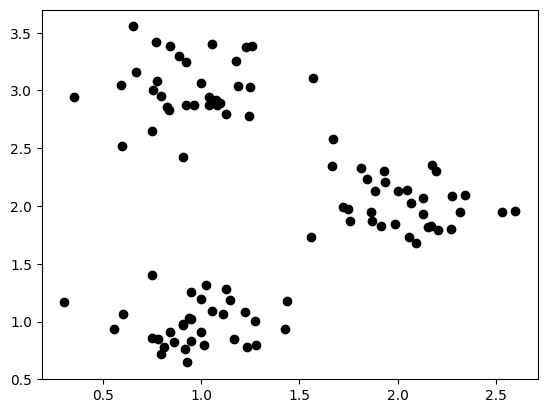

In [97]:
plt.plot(X[:, 0], X[:, 1], "ko")

TRAIN_SIZE = 4 * SAMPLE_SIZE // 5 # 80%
SAMPLE_SHUFFLE = SAMPLE.copy()
np.random.shuffle(SAMPLE_SHUFFLE)
X_train, X_test = SAMPLE_SHUFFLE[:TRAIN_SIZE, :2], SAMPLE_SHUFFLE[TRAIN_SIZE:, :2]
Y_train, Y_test = (
    SAMPLE_SHUFFLE[:TRAIN_SIZE, -1].astype(int),
    SAMPLE_SHUFFLE[TRAIN_SIZE:, -1].astype(int),
)

lda = LDA()
lda.fit(X_train, Y_train)
predict_train = lda.predict(X_train)
predict_test = lda.predict(X_test)
result_train = sum(predict_train == Y_train) / len(Y_train)
result_test = sum(predict_test == Y_test) / len(Y_test)

print(f"LDA accuracy: {result_train * 100:.2f}%")
print(f"LDA prediction: {result_test * 100:.2f}%")

sk LDA accuracy: 100.00%


<Axes: title={'center': 'Кластеры, разделённые вычисленными с помощью LDA гиперплоскостями'}>

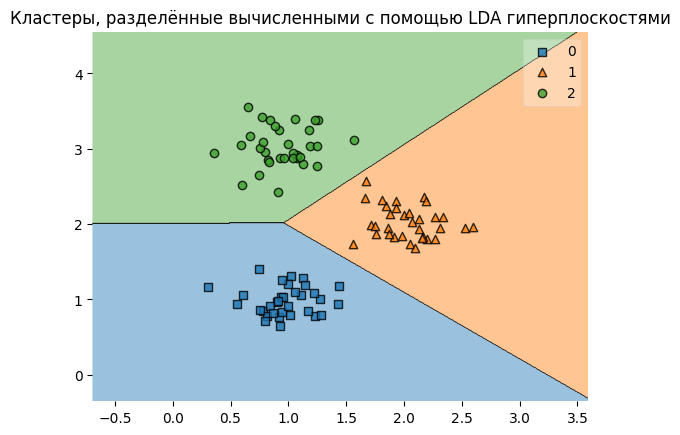

In [99]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score
from mlxtend.plotting import plot_decision_regions

sk_lda = LinearDiscriminantAnalysis(solver="eigen")
sk_lda.fit(X_train, Y_train)
sk_lda_pred_res = sk_lda.predict(X_test)
sk_lda_accuracy = accuracy_score(Y_test, sk_lda_pred_res)

print(f"sk LDA accuracy: {sk_lda_accuracy * 100:.2f}%")

plt.title("Кластеры, разделённые вычисленными с помощью LDA гиперплоскостями")
plot_decision_regions(X=X, y=Y, clf=sk_lda)